## Understand the Reference Video and Audio


### The purpose of this part is to discover the data and to see how the lip-sync model may perform in the produced videos.

-	Import the voices and the face video provided.
-	Implement “get_video_details” function it takes the video path and returns the details of the video. 
-	Implement “get_audio_details” function it takes also the video path and returns the sound details.
-	Implement “convert_sound_to_text_whisper” function this function is based on two model whisper model from openAi to translate the sound into text, the other model is “langdetec” it is a model to detect the language from its writing, the function takes audio path and split whether to only return the first word or not.
-	Investigating the 13_K.mp4 video.
-	Extract the face from 10 random frames Using the MTCNN model.
-	Extract the audio at the same time of the frames.
-	Save the sound clips in the audio folder to check them (all the collected data is available in google drive).
-	Translate the sound clips into words and detect the language.
-	Save the translation, the language, and the frame in a .txt file and print them.
-	Save the plot of the group of the random frames faces.


In [2]:
# install the required packages
!pip install gdown
! pip install moviepy

# sound to text model
!pip install git+https://github.com/openai/whisper.git
!pip install torch torchvision torchaudio
!pip install pydub

# lamguage detector
!pip install langdetect

# face detection model
! pip install  facenet-pytorch

  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-snler251
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-snler251
  Resolved https://github.com/openai/whisper.git to commit ba3f3cd54b0e5b8ce1ab3de13e32122d0d5f98ab
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)


In [2]:
# import the necessary libiraries
import os
import gdown
import cv2
from moviepy.editor import VideoFileClip
from pydub import AudioSegment
import whisper
from langdetect import detect, DetectorFactory
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
import random
from facenet_pytorch import MTCNN
import cv2
from google.colab.patches import cv2_imshow
import subprocess
import glob
from PIL import Image
from moviepy.editor import VideoFileClip
from pydub import AudioSegment
from random import sample
from pathlib import Path
from IPython.display import Audio

In [1]:
# mount my drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# import the data audios for the difference languages and the face video
# create directory to hold the *.Wav files and .Mp4
os.makedirs('/content/videos', exist_ok=True)
os.makedirs('/content/voices', exist_ok=True)


# import the data from the drive

# the face video URL
url = "https://drive.google.com/uc?id=******************************"

# Download the file
gdown.download(url, output="/content/videos/face.mp4", quiet=False)


# the English voice
# the download URL
url = "https://drive.google.com/uc?id=******************************"

# Download the file
gdown.download(url, output="/content/voices/Eng.wav", quiet=False)
"/content/Eng.wav"


# the Arabic voice
# the download URL
url = "https://drive.google.com/uc?id=******************************"

# Download the file
gdown.download(url, output="/content/voices/Arb.wav", quiet=False)
"/content/Arb.wav"


# the Spanish voice
# the download URL
url = "https://drive.google.com/uc?id=******************************"

# Download the file
gdown.download(url, output="/content/voices/Spa.wav", quiet=False)
"/content/Spa.wav"


# the Korean voice
# the download URL
url = "https://drive.google.com/uc?id=******************************"

# Download the file
gdown.download(url, output="/content/voices/Kor.wav", quiet=False)


In [4]:
# define the language ditionary
language_map = {
    'af': 'Afrikaans', 'ar': 'Arabic', 'bg': 'Bulgarian', 'bn': 'Bengali', 'bs': 'Bosnian',
    'ca': 'Catalan', 'cs': 'Czech', 'cy': 'Welsh', 'da': 'Danish', 'de': 'German',
    'el': 'Greek', 'en': 'English','es': 'Spanish', 'et': 'Estonian', 'fa': 'Persian',
    'fi': 'Finnish', 'fr': 'French', 'gu': 'Gujarati', 'he': 'Hebrew', 'hi': 'Hindi',
    'hr': 'Croatian', 'hu': 'Hungarian', 'id': 'Indonesian', 'it': 'Italian', 'ja': 'Japanese',
    'kn': 'Kannada', 'ko': 'Korean', 'lt': 'Lithuanian', 'lv': 'Latvian', 'mk': 'Macedonian',
    'ml': 'Malayalam', 'mr': 'Marathi', 'ne': 'Nepali', 'nl': 'Dutch', 'no': 'Norwegian',
    'pa': 'Punjabi', 'pl': 'Polish', 'pt': 'Portuguese', 'ro': 'Romanian', 'ru': 'Russian',
    'si': 'Sinhala','sk': 'Slovak', 'sl': 'Slovenian', 'sq': 'Albanian','sv': 'Swedish',
    'sw': 'Swahili', 'ta': 'Tamil', 'te': 'Telugu', 'th': 'Thai', 'tl': 'Tagalog',
    'tr': 'Turkish', 'uk': 'Ukrainian', 'ur': 'Urdu', 'vi': 'Vietnamese', 'zh-cn': 'Chinese (Simplified)', 'zh-tw': 'Chinese (Traditional)'
}

In [5]:
#function to find the details of the video

def get_video_details(video_path):
    # Load video file
    clip = VideoFileClip(video_path)

    # Extract video details
    width, height = clip.size
    fps = clip.fps
    duration = clip.duration
    frame_count = int(duration * fps)

    # Print video details
    print(f"Resolution: {width}x{height}")
    print(f"Frames per Second: {fps}")
    print(f"Total Frames: {frame_count}")
    print(f"Duration (seconds): {duration:.2f}")



# function to find the details of the sound

def get_audio_details(audio_path):
    # Load audio file
    audio = AudioSegment.from_file(audio_path)

    # Extract audio details
    duration = len(audio) / 1000.0  # Duration in seconds
    sample_rate = audio.frame_rate
    n_channels = audio.channels
    n_samples = len(audio.raw_data) // audio.sample_width

    # Print audio details
    print(f"Duration (seconds): {duration:.2f}")
    print(f"Sample Rate: {sample_rate} Hz")
    print(f"Number of Channels: {n_channels}")
    print(f"Number of Samples: {n_samples}")


# function to detect to print the text and the langugae

# Set seed for reproducibility
DetectorFactory.seed = 0

def convert_sound_to_text_whisper(audio_file_path,split=False, model_size="base"):
    # Convert audio file to mono if it's not already
    audio = AudioSegment.from_file(audio_file_path)
    audio = audio.set_channels(1)
    mono_audio_path = "mono_audio.wav"
    audio.export(mono_audio_path, format="wav")

    # Load Whisper model
    model = whisper.load_model(model_size)

    # Transcribe audio to text
    result = model.transcribe(mono_audio_path)

    if split:
        text = result["text"].strip().split(" ")[0]
    else:
        text = result["text"]

    # Detect language of the transcribed text
    try:
        language_code = detect(text)
        language = language_map.get(language_code, "Unknown")
    except Exception as e:
        print(f"Language detection failed: {e}")
        language = None

    return text, language



# Basic Video and Audio Analysis

In [6]:
# find the details of 13_K.Mp4

video_path = "/content/videos/face.mp4"
get_video_details(video_path)


Resolution: 1080x1920
Frames per Second: 25.0
Total Frames: 777
Duration (seconds): 31.10


In [7]:
# find the details of the voice sound tracks

base_url = '/content/voices'
all_links = []
for item in os.listdir(base_url):
    item_path = os.path.join(base_url, item)
    all_links.append(str(item_path))


# find the detail of the voices in the voices folder
for i in all_links:
    print(i.split("/")[-1])
    get_audio_details(i)
    print("\n")

Arb.wav
Duration (seconds): 55.34
Sample Rate: 48000 Hz
Number of Channels: 2
Number of Samples: 5312512


Spa.wav
Duration (seconds): 23.77
Sample Rate: 48000 Hz
Number of Channels: 2
Number of Samples: 2281472


Eng.wav
Duration (seconds): 40.41
Sample Rate: 48000 Hz
Number of Channels: 2
Number of Samples: 3878912


Kor.wav
Duration (seconds): 42.60
Sample Rate: 48000 Hz
Number of Channels: 2
Number of Samples: 4089856




# Translate the sound to Text and define the spoken Languge

In [ ]:
# find the text and language of the voices in the videos folder

text, lang =convert_sound_to_text_whisper("/content/videos/face.mp4")
print("The Text is:",text)
print("The Spoken Language is" ,lang)

The Text is:  스마트 미션에는 대화형 AI를 사용해 인간 개입 없이 고객과 상호작용하고 필요한 서비스를 제공하는 최초의 인간 크기 홀로그램이 포함되며 홀로그램은 라이브 텔러 옵션과도 연결됩니다. 이를 통해 라이브 에이전트를 실시간으로 홀로그램으로 변환할 수 있습니다. 이는 전 세계 최초의 셀프 서비스 구현으로 고객이 필요할 경우 눈 앞에 있는 실시간 상담원과 직접 상호작용할 수 있습니다.
The Spoken Language is Korean


In [ ]:
# find the text and language of the voices in the voices folder
for i in all_links:
    print("saved track ",i.split("/")[-1])
    text, lang =convert_sound_to_text_whisper(i)
    print("The Text is:",text)
    print("The Spoken Language is" ,lang)
    print("\n")

saved track  Arb.wav
The Text is:  إذا ظهر الخطأ في الصفحة الأولى للخدمة يرجع التأكود من إدخال جميع البيانات بالشكل الصحيح عند الانتقال إلى الصفحة ثانية من تقديم الطلب يرجع التأكود من النقر على خيار إتمام الدفع ومن ثم الموافقى على الشروط والأحكام أما إذا ظهر الخطأ في الصفحة الخاصة بإدخال بيانات بتاقة الدفع فغالبا ما يكون سبب ذلك أن بيانات بتاقة الدفع التي تم إدخالها قد تكون خاطئة أو أنه يتعيّا عليكم التواصل مع البنك الخاص بكم لأن بعض البنوك تلجأ إلى تقيد استخدام البطاقة خارج الدولة أو قد يكون الخطأ ناتجا عن أسباب إدارية أو تقنيّة وعندها سيكون لدى البنك الصلاحية لمتابعة الموضوع وأبلاغيكم بالسبب وحل المشكلة وبالإمكان في حينها إعاد التعبئة الطلب وتجربة الدفع مجدداً
The Spoken Language is Arabic


saved track  Eng.wav
The Text is:  If the error is displayed on the first page of the service, please enter all data correctly. Moving to the second page of the application, please make sure to click on the complete payment option, then agree to the terms and conditions. However, if the error app

# Video Lip_sync Analysis

## In This section i will investigate the mentioned video
- Extract the face from 10 random frames Using the MTCNN model
- Extract the audio at the same time of the frames
- Save the sound clips in the audio folder to check them
- Translate the sound clips into words and detect the language
- Save the translation, the language, and the frame in a .txt file and print them

In [11]:

# create a frame new folder
os.makedirs('/content/drive/MyDrive/project/Task1/frames', exist_ok=True)

# convert the video into frames
subprocess.run(['ffmpeg', '-i', '/content/videos/face.mp4', '-vf', 'fps=25', '/content/drive/MyDrive/project/Task1/frames/frame_%06d.png'])

# create a list of the frames in the frames folder
base_url = '/content/drive/MyDrive/project/Task1/frames'
all_frame_links = []
for item in os.listdir(base_url):
    item_path = os.path.join(base_url, item)
    all_frame_links.append(str(item_path))

# pick random links from the frames folder
ind = random.sample(range(len(all_frame_links)), 10)
cropped_images = []

# Initialize MTCNN
mtcnn = MTCNN(keep_all=True, device='cpu')

for i in ind:
    img = cv2.imread(all_frame_links[i])
    boxes, _ = mtcnn.detect(img)
    x1, y1, x2, y2 = map(int, boxes[0])
    cropped_img = img[y1:y2, x1:x2]

    # add the face into the cropped_images list
    cropped_images.append(cropped_img)


In [12]:
# create a direcorty for the croped audios
os.makedirs('/content/drive/MyDrive/project/Task1/audio/', exist_ok=True)

# Function to extract audio segment from the video
def extract_audio_segment(video_path,save_path, start_time, duration=2):
    video = VideoFileClip(video_path)
    audio = video.audio.subclip(start_time, start_time + duration)
    audio_path = f"{save_path}audio_at_{start_time}.wav"
    audio.write_audiofile(audio_path)
    return audio_path

# create the audio segments and save them to the audio folder
path_list=[]
for i in ind:
    path = extract_audio_segment("/content/videos/face.mp4", "/content/drive/MyDrive/project/Task1/audio/", i/25)
    path_list.append(path)


chunk:  33%|███▎      | 15/45 [01:29<02:58,  5.97s/it, now=None]

MoviePy - Writing audio in /content/drive/MyDrive/project/Task1/audio/audio_at_26.28.wav



chunk:  33%|███▎      | 15/45 [01:29<02:59,  5.98s/it, now=None]

MoviePy - Done.


chunk:  33%|███▎      | 15/45 [01:30<03:00,  6.01s/it, now=None]

MoviePy - Writing audio in /content/drive/MyDrive/project/Task1/audio/audio_at_2.52.wav



chunk:  33%|███▎      | 15/45 [01:30<03:00,  6.02s/it, now=None]

MoviePy - Done.


chunk:  33%|███▎      | 15/45 [01:30<03:01,  6.05s/it, now=None]

MoviePy - Writing audio in /content/drive/MyDrive/project/Task1/audio/audio_at_15.8.wav



chunk:  33%|███▎      | 15/45 [01:30<03:01,  6.06s/it, now=None]

MoviePy - Done.


chunk:  33%|███▎      | 15/45 [01:31<03:02,  6.09s/it, now=None]

MoviePy - Writing audio in /content/drive/MyDrive/project/Task1/audio/audio_at_4.92.wav



chunk:  33%|███▎      | 15/45 [01:31<03:02,  6.10s/it, now=None]

MoviePy - Done.


chunk:  33%|███▎      | 15/45 [01:31<03:03,  6.13s/it, now=None]

MoviePy - Writing audio in /content/drive/MyDrive/project/Task1/audio/audio_at_24.56.wav



chunk:  33%|███▎      | 15/45 [01:32<03:04,  6.14s/it, now=None]

MoviePy - Done.


chunk:  33%|███▎      | 15/45 [01:32<03:05,  6.17s/it, now=None]

MoviePy - Writing audio in /content/drive/MyDrive/project/Task1/audio/audio_at_0.96.wav



chunk:  33%|███▎      | 15/45 [01:32<03:05,  6.18s/it, now=None]

MoviePy - Done.


chunk:  33%|███▎      | 15/45 [01:33<03:06,  6.21s/it, now=None]

MoviePy - Writing audio in /content/drive/MyDrive/project/Task1/audio/audio_at_5.72.wav



chunk:  33%|███▎      | 15/45 [01:33<03:06,  6.22s/it, now=None]

MoviePy - Done.


chunk:  33%|███▎      | 15/45 [01:33<03:07,  6.25s/it, now=None]

MoviePy - Writing audio in /content/drive/MyDrive/project/Task1/audio/audio_at_28.64.wav



chunk:  33%|███▎      | 15/45 [01:34<03:08,  6.28s/it, now=None]

MoviePy - Done.


chunk:  33%|███▎      | 15/45 [01:34<03:09,  6.30s/it, now=None]

MoviePy - Writing audio in /content/drive/MyDrive/project/Task1/audio/audio_at_16.32.wav



chunk:  33%|███▎      | 15/45 [01:34<03:09,  6.31s/it, now=None]

MoviePy - Done.


chunk:  33%|███▎      | 15/45 [01:35<03:10,  6.34s/it, now=None]

MoviePy - Writing audio in /content/drive/MyDrive/project/Task1/audio/audio_at_9.48.wav



chunk:  33%|███▎      | 15/45 [01:35<03:10,  6.35s/it, now=None]

MoviePy - Done.


In [13]:
# loop over the audio links and translate the sound to words for each frame

writing =[]
c=0
for i in path_list:
    text, lang =convert_sound_to_text_whisper(i,split =True)
    writing.append(f"for {all_frame_links[c].split('000')[-1]} The Text is:{text} The Language is {lang} \n")
    c+=1



  0%|                                               | 0.00/139M [00:00<?, ?iB/s]
  2%|▋                                     | 2.52M/139M [00:00<00:05, 26.3MiB/s]
  8%|███                                   | 11.3M/139M [00:00<00:02, 65.2MiB/s]
 13%|████▊                                 | 17.6M/139M [00:00<00:02, 43.4MiB/s]
 18%|██████▊                               | 24.7M/139M [00:00<00:02, 53.0MiB/s]
 23%|████████▋                             | 31.4M/139M [00:00<00:01, 58.2MiB/s]
 27%|██████████▎                           | 37.5M/139M [00:00<00:02, 50.6MiB/s]
 31%|███████████▊                          | 43.3M/139M [00:00<00:01, 53.2MiB/s]
 38%|██████████████▎                       | 52.1M/139M [00:00<00:01, 64.1MiB/s]
 44%|████████████████▊                     | 61.1M/139M [00:01<00:01, 72.6MiB/s]
 49%|██████████████████▊                   | 68.4M/139M [00:01<00:01, 68.9MiB/s]
 54%|████████████████████▋                 | 75.3M/139M [00:01<00:00, 68.9MiB/s]
 59%|██████████████████████

In [14]:
# write the translation to a txt file
with open('/content/drive/MyDrive/project/Task1/output.txt', 'w') as f:
  for line in writing:
    f.write(line)

In [15]:
# the writings letters are not defiv=ned in matplotlib so i saved them in .txt file and print them
for i in writing:
    print(i)

for 001.png The Text is:눈 The Language is Korean 

for 002.png The Text is:AI를 The Language is Tagalog 

for 003.png The Text is:에이전트를 The Language is Korean 

for 004.png The Text is:고객과 The Language is Korean 

for 005.png The Text is:고객이 The Language is Korean 

for 006.png The Text is:마트 The Language is Korean 

for 007.png The Text is:자용하고 The Language is Korean 

for 008.png The Text is:직접 The Language is Korean 

for 009.png The Text is:마트 The Language is Korean 

for 010.png The Text is:홀로그램이 The Language is Korean 



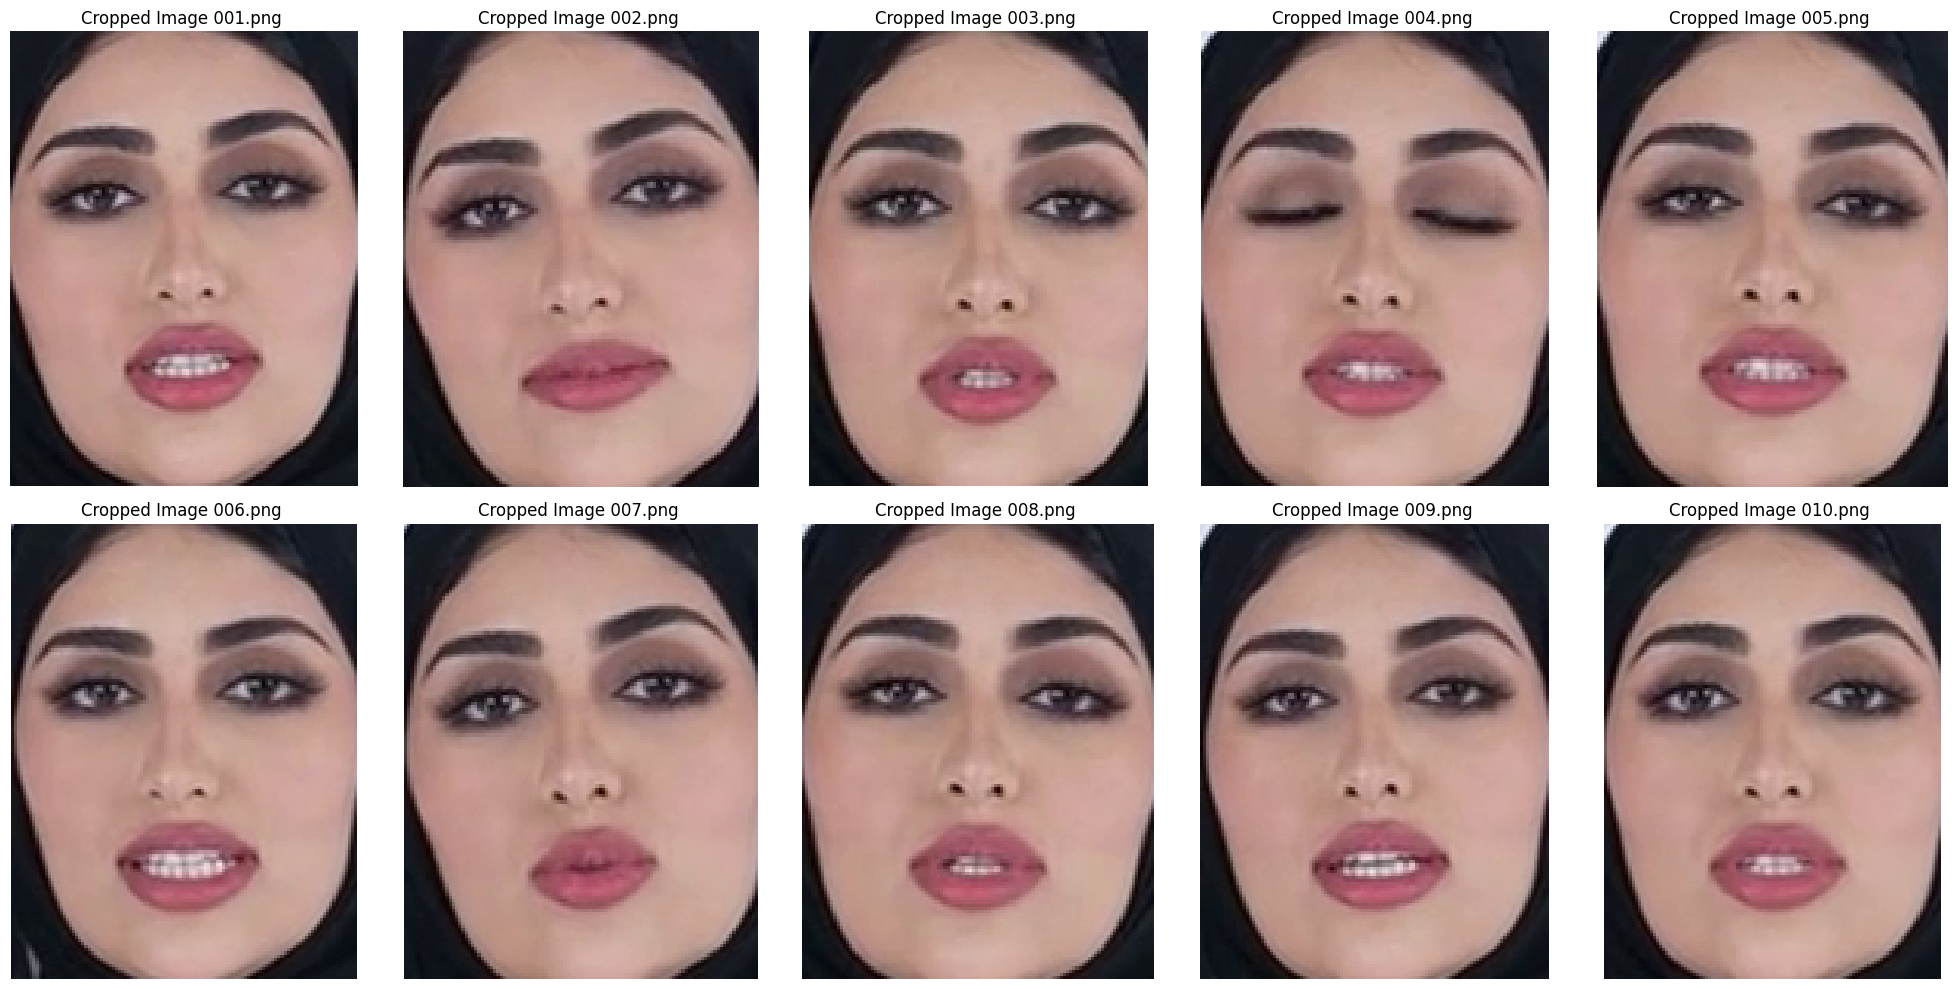

In [17]:

# plot the generated faces
plt.figure(figsize=(20, 10))  # Adjust width and height as needed

for i, cropped_img in enumerate(cropped_images):
    ax = plt.subplot(2, 5, i + 1)
    ax.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
    ax.set_title(f"Cropped Image {all_frame_links[i].split('000')[-1]} ")
    ax.axis('off')

plt.tight_layout()

#save the figure to the drive
plt.savefig('/content/drive/MyDrive/project/Task1/cropped_faces.png')

plt.show()

